In [59]:
from tqdm import tqdm
import pandas as pd
from tabulate import tabulate
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib

In [60]:
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

In [61]:
TEST_SIZE = 0.2
VAL_SIZE = 0.2
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.01
SEQ_LENGTH = 24
DATA = './data/meteo_16.9_51.103333_2025-11-30_2022-11-13.csv' 

TARGET_FET = 'apparent_temperature'
DROP_FEATURES = ['date', 'hour', 'dayofyear']

MODEL_NAME = 'model_v3_LSTM'
SAVE_PATH = './models'

In [62]:
df = pd.read_csv(DATA)
df['date'] = pd.to_datetime(df['date'])

df["hour"] = df["date"].dt.hour
df["dayofyear"] = df["date"].dt.dayofyear

df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["dayofyear_sin"] = np.sin(2 * np.pi * df["dayofyear"] / 365)
df["dayofyear_cos"] = np.cos(2 * np.pi * df["dayofyear"] / 365)

print(tabulate(df.head(), headers='keys', tablefmt='psql'))

+----+---------------------------+------------------+------------------------+------------------------+--------------------+----------------------+------------------+------------------------+--------------------------+----------------+-----------+--------+----------------+------------+--------------+---------------+--------+-------------+------------+--------------+-----------------+-----------------+
|    | date                      |   temperature_2m |   relative_humidity_2m |   apparent_temperature |   surface_pressure |   wind_direction_10m |   wind_speed_10m |   soil_temperature_0cm |   soil_moisture_0_to_1cm |   pressure_msl |   showers |   rain |   dew_point_2m |   snowfall |   snow_depth |   cloud_cover |   hour |   dayofyear |   hour_sin |     hour_cos |   dayofyear_sin |   dayofyear_cos |
|----+---------------------------+------------------+------------------------+------------------------+--------------------+----------------------+------------------+------------------------

In [63]:
df_len = len(df)

train_end = int(df_len * (1 - TEST_SIZE - VAL_SIZE))
val_end = int(df_len * (1 - TEST_SIZE))

train_df = df.iloc[:train_end].copy()
val_df = df.iloc[train_end:val_end].copy()
test_df = df.iloc[val_end:].copy()

print(f'Train size: {len(train_df)}')
print(f'Validation size: {len(val_df)}')
print(f'Test size: {len(test_df)}')

Train size: 16032
Validation size: 5344
Test size: 5345


In [64]:
def split_Xy(dataset):
    X = dataset.drop(columns=DROP_FEATURES + [TARGET_FET])
    y = dataset[TARGET_FET]
    return X, y

X_train, y_train = split_Xy(train_df)
X_val, y_val = split_Xy(val_df)
X_test, y_test = split_Xy(test_df)


scaler_X = StandardScaler()
scaler_y = StandardScaler()

scaler_X.fit(X_train)
scaler_y.fit(y_train.values.reshape(-1, 1))

X_train_scaled = scaler_X.transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

print(pd.DataFrame(X_train_scaled).describe())
print(pd.DataFrame(y_train_scaled).describe())

                 0             1             2             3             4   \
count  1.603200e+04  1.603200e+04  1.603200e+04  1.603200e+04  1.603200e+04   
mean  -3.403798e-16 -2.694673e-16  1.045249e-14 -1.010502e-16  7.800369e-17   
std    1.000031e+00  1.000031e+00  1.000031e+00  1.000031e+00  1.000031e+00   
min   -2.987726e+00 -3.344181e+00 -3.610578e+00 -2.205717e+00 -1.765146e+00   
25%   -7.859165e-01 -6.086021e-01 -5.982553e-01 -7.978515e-01 -7.477887e-01   
50%   -4.711302e-02  2.424667e-01  5.088956e-02  1.525474e-01 -1.575874e-01   
75%    7.792956e-01  7.895824e-01  6.254756e-01  8.713643e-01  5.492384e-01   
max    2.765012e+00  1.519070e+00  3.276681e+00  1.795179e+00  5.357747e+00   

                 5             6             7             8             9   \
count  1.603200e+04  1.603200e+04  1.603200e+04  1.603200e+04  1.603200e+04   
mean  -1.701899e-16 -5.956646e-16  1.162964e-14  1.772811e-18  3.722904e-17   
std    1.000031e+00  1.000031e+00  1.000031e+00  1.

In [65]:
def create_seq(scaled_X, scaled_y, seq_length):
    sequences = []
    targets = []
    
    for i in tqdm(range(len(scaled_X) - seq_length)):
        seq_X = scaled_X[i:i+seq_length]
        seq_y = scaled_y[i+seq_length]
        sequences.append(seq_X)
        targets.append(seq_y)
    return np.array(sequences), np.array(targets)

X_train_seq, y_train_seq = create_seq(X_train_scaled, y_train_scaled, SEQ_LENGTH)
X_val_seq, y_val_seq = create_seq(X_val_scaled, y_val_scaled, SEQ_LENGTH)
X_test_seq, y_test_seq = create_seq(X_test_scaled, y_test_scaled, SEQ_LENGTH)
print()
print(f'Train sequences: {X_train_seq.shape}, Train targets: {y_train_seq.shape}')
print(f'Validation sequences: {X_val_seq.shape}, Validation targets: {y_val_seq.shape}')
print(f'Test sequences: {X_test_seq.shape}, Test targets: {y_test_seq.shape}')

  0%|          | 0/16008 [00:00<?, ?it/s]

100%|██████████| 5321/5321 [00:00<00:00, 1397051.12it/s]


Train sequences: (16008, 24, 18), Train targets: (16008,)
Validation sequences: (5320, 24, 18), Validation targets: (5320,)
Test sequences: (5321, 24, 18), Test targets: (5321,)


In [66]:
model = tf.keras.Sequential(name=MODEL_NAME)
model.add(tf.keras.layers.InputLayer(shape=(SEQ_LENGTH, X_train_seq.shape[2])))
model.add(tf.keras.layers.LSTM(128, return_sequences=True, activation='tanh'))
model.add(tf.keras.layers.LSTM(64, activation='tanh'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
    loss=tf.keras.losses.Huber(), 
    metrics=['mae'])

print(model.summary())

Model: "model_v3_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 24, 128)        │        75,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,897 (503.50 KB)

 Trainable params: 128,897 (503.50 KB)

 Non-trainable params: 0 (0.00 B)

None


In [67]:
monitors = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.10, patience=3, min_lr=1e-6, verbose=1)
]
history = model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=monitors)

Epoch 1/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - loss: 0.0130 - mae: 0.1029 - val_loss: 0.0036 - val_mae: 0.0637 - learning_rate: 0.0100
Epoch 2/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.0039 - mae: 0.0653 - val_loss: 0.0030 - val_mae: 0.0585 - learning_rate: 0.0100
Epoch 3/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.0036 - mae: 0.0623 - val_loss: 0.0031 - val_mae: 0.0599 - learning_rate: 0.0100
Epoch 4/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.0034 - mae: 0.0610 - val_loss: 0.0029 - val_mae: 0.0572 - learning_rate: 0.0100
Epoch 5/100
500/501 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0033 - mae: 0.0593
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
501/501 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.0033 - mae: 0.0599 - val_loss: 0.0031 - val_mae: 0.0592 - learning_rate: 0.0100
Epoch 6/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.0021 - mae: 0.0463 - val_loss: 0.0020 - val_mae: 0.0458 - learn

In [68]:
os.makedirs(os.path.join(SAVE_PATH, MODEL_NAME), exist_ok=True)
model.save(os.path.join(SAVE_PATH, MODEL_NAME, 'model.keras'))
joblib.dump(scaler_X, os.path.join(SAVE_PATH, MODEL_NAME, 'scaler_X.pkl'))
joblib.dump(scaler_y, os.path.join(SAVE_PATH, MODEL_NAME, 'scaler_y.pkl'))

['./models/model_v3_LSTM/scaler_y.pkl']

=== TRAINING ===


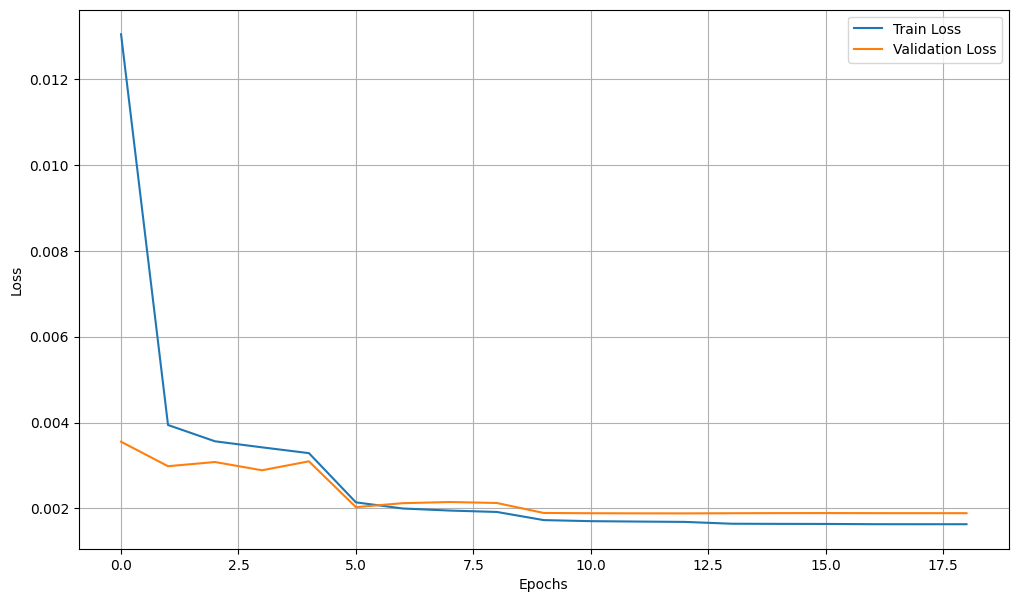

In [69]:
print("=== TRAINING ===")
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()
    

In [70]:
mae_scaled = model.evaluate(X_test_seq, y_test_seq, verbose=0)[1]

pred_scaled = model.predict(X_test_seq).flatten()
pred_rescaled = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
test_y_rescaled = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

print()
print("=== TEST ===")

mae = np.mean(np.abs(pred_rescaled - test_y_rescaled))
print(f'Test MAE on scaled data: {mae_scaled:.3f}')
print(f'Test MAE rescaled to original values: {mae:.3f}')

print()

comp_tab = pd.DataFrame({
    'Data': test_df['date'].iloc[SEQ_LENGTH:SEQ_LENGTH + len(test_y_rescaled)].reset_index(drop=True),
    'Actual': test_y_rescaled,
    'Predicted': pred_rescaled
})
comp_tab = comp_tab.sort_values(by='Data')

print(tabulate(comp_tab, headers='keys', tablefmt='psql'))

167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step

=== TEST ===
Test MAE on scaled data: 0.051
Test MAE rescaled to original values: 0.523

+------+---------------------------+-------------+--------------+
|      | Data                      |      Actual |    Predicted |
|------+---------------------------+-------------+--------------|
|    0 | 2025-04-23 06:00:00+00:00 | 11.3463     | 11.6792      |
|    1 | 2025-04-23 07:00:00+00:00 | 13.9019     | 13.6942      |
|    2 | 2025-04-23 08:00:00+00:00 | 16.1089     | 14.8547      |
|    3 | 2025-04-23 09:00:00+00:00 | 17.0914     | 16.9296      |
|    4 | 2025-04-23 10:00:00+00:00 | 17.8044     | 18.5148      |
|    5 | 2025-04-23 11:00:00+00:00 | 19.033      | 19.0166      |
|    6 | 2025-04-23 12:00:00+00:00 | 20.2122     | 20.0013      |
|    7 | 2025-04-23 13:00:00+00:00 | 20.3525     | 19.8091      |
|    8 | 2025-04-23 14:00:00+00:00 | 20.1171     | 20.2001      |
|    9 | 2025-04-23 15:00:00+00:00 | 19.0434     | 19.2041      |
|   10 | 2

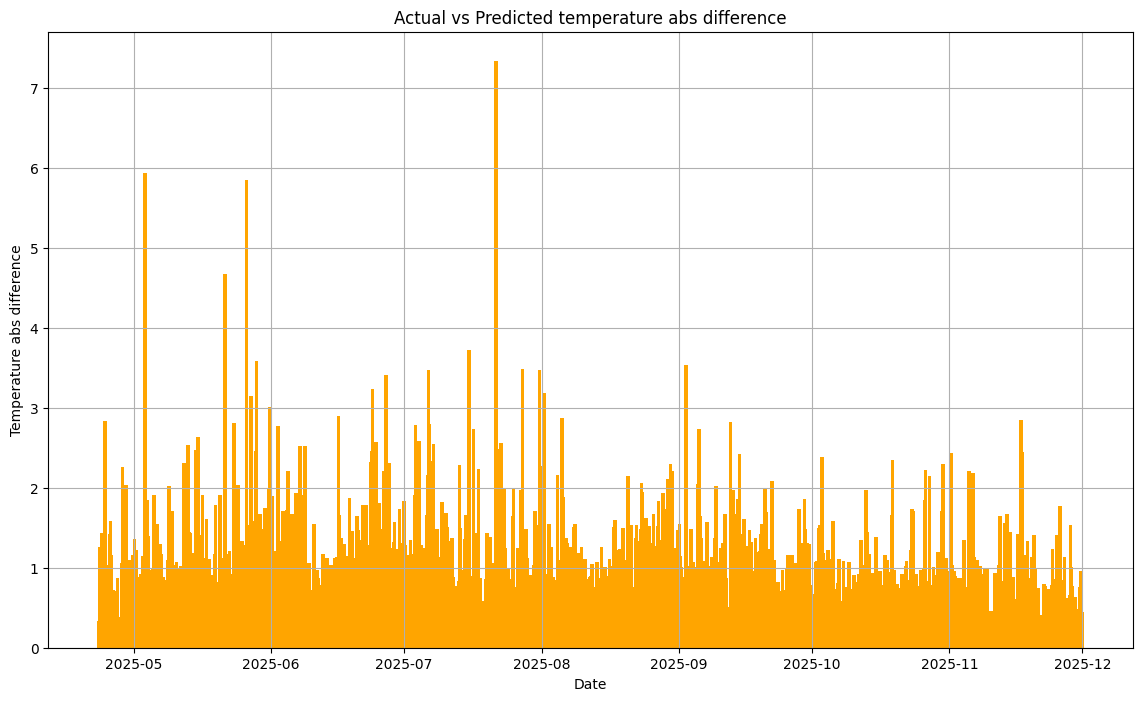

In [71]:
plt.figure(figsize=(14, 8))
diff = np.abs(comp_tab['Actual'] - comp_tab['Predicted'])
plt.bar(comp_tab['Data'], diff, color='orange')
plt.xlabel('Date')
plt.ylabel('Temperature abs difference')
plt.title('Actual vs Predicted temperature abs difference')
plt.grid()
plt.show()

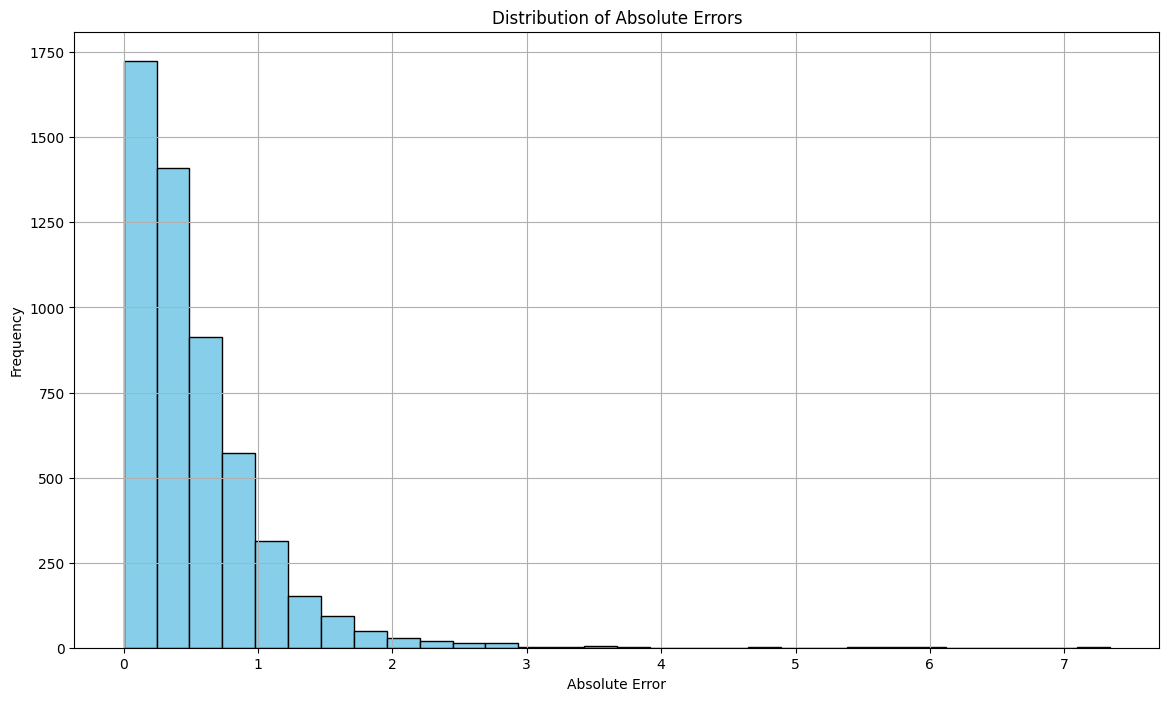

In [72]:
plt.figure(figsize=(14, 8))
plt.hist(diff, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.title('Distribution of Absolute Errors')
plt.grid()
plt.show()